<a href="https://colab.research.google.com/github/irbaadika/Malnutrition_Analysis/blob/main/Malnutrition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Mount to drive

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
!pip install  geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import max
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [53]:
spark = SparkSession.builder.appName("MalnutritionAnalysis").getOrCreate()

In [54]:
data = spark.read.csv("/content/drive/MyDrive/Big Data/PROJECT/WorldMalnutrition.csv", header=True, inferSchema=True)
data.head()

Row(Country='Afghanistan', Indicator='Under-five mortality rate', Sex='Female', TIME_PERIOD=2010, OBS_VALUE=84.17642561, Unit of Measure='Deaths per 1000 live births')

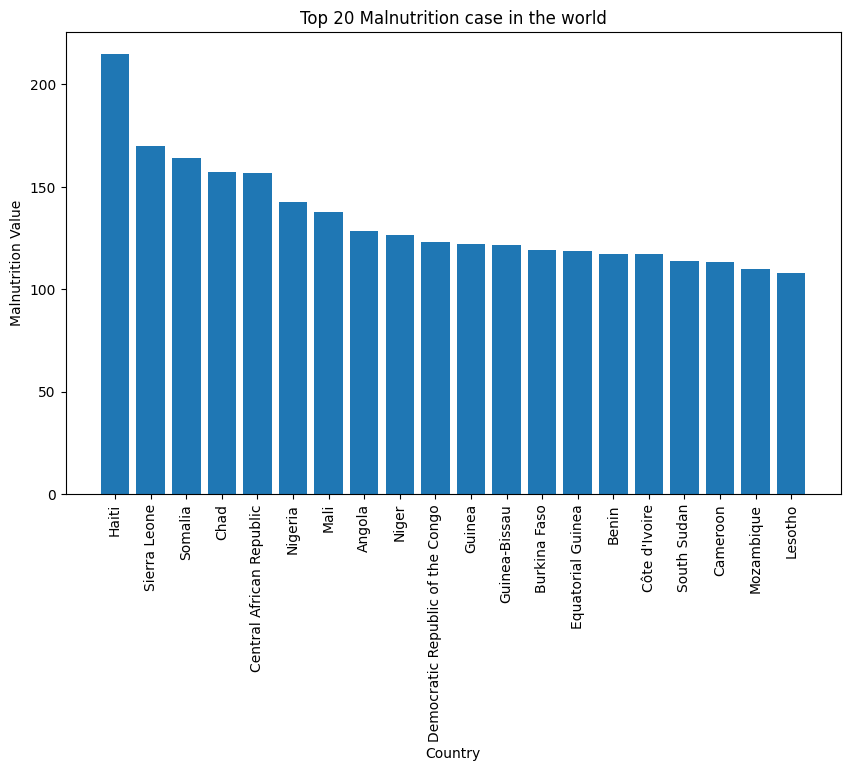

In [55]:
data_new= data.select("TIME_PERIOD", "Country", "Sex", "Indicator", "OBS_VALUE"). \
            withColumnRenamed("TIME_PERIOD", "time_period"). \
            withColumnRenamed("Country", "country"). \
            withColumnRenamed("Sex", "sex"). \
            withColumnRenamed("Indicator", "indicator"). \
            withColumnRenamed("OBS_VALUE", "obs_value")
data_new = data_new.filter((data_new["obs_value"].isNotNull()) & (data["obs_value"] >= 0))
data_new = data_new.withColumn("TIME_PERIOD", data_new["time_period"].cast("integer"))
max_obs = data_new.groupBy("country", "indicator").agg(max("obs_value").alias("max_obs_value"))
max_obs = max_obs.alias("max_obs")
data_new = data_new.alias("data_new")
result = max_obs.join(data_new,
		      (max_obs["indicator"] == data_new["data_new.indicator"]) &
		      (max_obs["country"] == data_new["data_new.country"]) &
                      (max_obs["max_obs.max_obs_value"] == data_new["data_new.obs_value"])
                     ).select( "max_obs.indicator", "data_new.country", "max_obs.max_obs_value")
result = result.orderBy("max_obs_value", ascending=False).limit(20)
result = result.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(result["country"], result["max_obs_value"])
plt.xlabel("Country")
plt.ylabel("Malnutrition Value")
plt.title("Top 20 Malnutrition case in the world")
plt.xticks(rotation=90)
plt.show()

In [56]:
data_new= data.select("TIME_PERIOD", "Country", "Sex", "Indicator", "OBS_VALUE"). \
            withColumnRenamed("TIME_PERIOD", "time_period"). \
            withColumnRenamed("Country", "country"). \
            withColumnRenamed("Sex", "sex"). \
            withColumnRenamed("Indicator", "indicator"). \
            withColumnRenamed("OBS_VALUE", "obs_value")
data_new = data_new.filter((data_new["obs_value"].isNotNull()) & (data["obs_value"] >= 0))
data_new = data_new.withColumn("TIME_PERIOD", data_new["time_period"].cast("integer"))
max_obs = data_new.groupBy("country", "indicator").agg(max("obs_value").alias("max_obs_value"))
max_obs = max_obs.alias("max_obs")
data_new = data_new.alias("data_new")
result = max_obs.join(data_new,
		      (max_obs["indicator"] == data_new["data_new.indicator"]) &
		      (max_obs["country"] == data_new["data_new.country"]) &
          (max_obs["max_obs.max_obs_value"] == data_new["data_new.obs_value"])
          ).select( "max_obs.indicator", "data_new.country", "max_obs.max_obs_value")
selected_columns = ["country", "indicator", "max_obs_value"]
assembler = VectorAssembler(inputCols=selected_columns[2:], outputCol="features")
df_transformed = assembler.transform(result)
(trainingData, testData) = df_transformed.randomSplit([0.8, 0.2])
lr = LinearRegression(featuresCol="features", labelCol="max_obs_value")
model = lr.fit(trainingData)
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="max_obs_value", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RSME : ", rmse)
predictions.show(5)

RSME :  1.1844845834669405e-14
+--------------------+------------------+-------------+-----------+------------------+
|           indicator|           country|max_obs_value|   features|        prediction|
+--------------------+------------------+-------------+-----------+------------------+
|Height-for-age <-...|           Albania|    11.632392|[11.632392]|11.632392000000012|
|Height-for-age <-...|           Algeria|     12.62638| [12.62638]|12.626380000000012|
|Height-for-age <-...|            Bhutan|    33.580147|[33.580147]|33.580147000000004|
|Height-for-age <-...|              Chad|    40.883522|[40.883522]|40.883522000000006|
|Height-for-age <-...|Dominican Republic|    8.0983067|[8.0983067]| 8.098306700000013|
+--------------------+------------------+-------------+-----------+------------------+
only showing top 5 rows



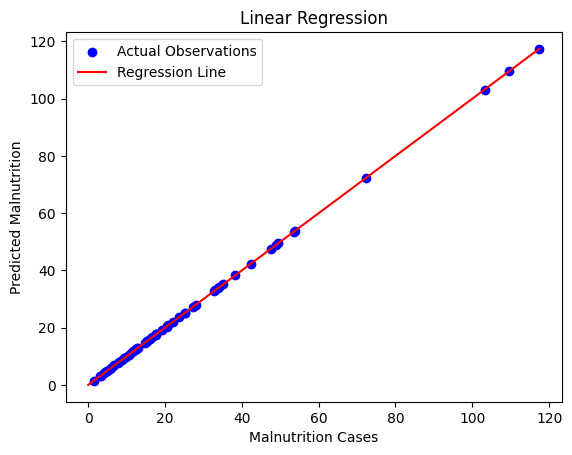

In [79]:
data_new= data.select("TIME_PERIOD", "Country", "Sex", "Indicator", "OBS_VALUE"). \
            withColumnRenamed("TIME_PERIOD", "time_period"). \
            withColumnRenamed("Country", "country"). \
            withColumnRenamed("Sex", "sex"). \
            withColumnRenamed("Indicator", "indicator"). \
            withColumnRenamed("OBS_VALUE", "obs_value")
data_new = data_new.filter((data_new["obs_value"].isNotNull()) & (data["obs_value"] >= 0))
data_new = data_new.withColumn("TIME_PERIOD", data_new["time_period"].cast("integer"))
max_obs = data_new.groupBy("country", "indicator").agg(max("obs_value").alias("max_obs_value"))
max_obs = max_obs.alias("max_obs")
data_new = data_new.alias("data_new")
result = max_obs.join(data_new,
		      (max_obs["indicator"] == data_new["data_new.indicator"]) &
		      (max_obs["country"] == data_new["data_new.country"]) &
                      (max_obs["max_obs.max_obs_value"] == data_new["data_new.obs_value"])
                     ).select( "max_obs.indicator", "data_new.country", "max_obs.max_obs_value")
selected_columns = ["country", "indicator", "max_obs_value"]
assembler = VectorAssembler(inputCols=selected_columns[2:], outputCol="features")
df_transformed = assembler.transform(result)
(trainingData, testData) = df_transformed.randomSplit([0.8, 0.2])
lr = LinearRegression(featuresCol="features", labelCol="max_obs_value")
model = lr.fit(trainingData)
predictions = model.transform(testData)
predicted_values = predictions.select("prediction").toPandas()["prediction"].tolist()
max_obs_value = predictions.select("max_obs_value").toPandas()["max_obs_value"].tolist()
plt.scatter(max_obs_value, predicted_values, color="blue", label="Actual Observations")
max_obs_max_value = np.max(max_obs_value)
max_pred_value = np.max(predicted_values)
plt.plot([0, max_obs_max_value], [0, max_pred_value], color="red", label="Regression Line")
plt.xlabel("Malnutrition Cases")
plt.ylabel("Predicted Malnutrition")
plt.title("Linear Regression")
plt.legend()
plt.show()

<ipython-input-57-f555ecc9be55>:27: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


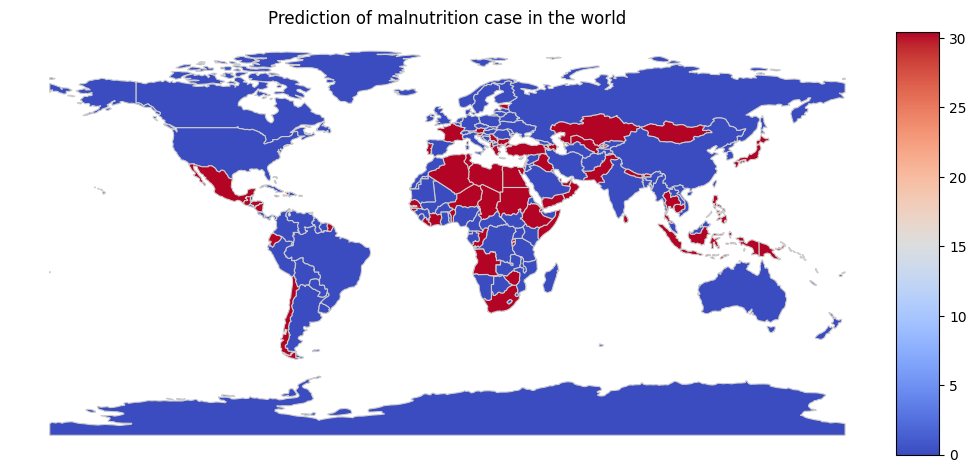

In [57]:
data_new= data.select("TIME_PERIOD", "Country", "Sex", "Indicator", "OBS_VALUE"). \
            withColumnRenamed("TIME_PERIOD", "time_period"). \
            withColumnRenamed("Country", "country"). \
            withColumnRenamed("Sex", "sex"). \
            withColumnRenamed("Indicator", "indicator"). \
            withColumnRenamed("OBS_VALUE", "obs_value")
data_new = data_new.filter((data_new["obs_value"].isNotNull()) & (data["obs_value"] >= 0))
data_new = data_new.withColumn("TIME_PERIOD", data_new["time_period"].cast("integer"))
max_obs = data_new.groupBy("country", "indicator").agg(max("obs_value").alias("max_obs_value"))
max_obs = max_obs.alias("max_obs")
data_new = data_new.alias("data_new")
result = max_obs.join(data_new,
		      (max_obs["indicator"] == data_new["data_new.indicator"]) &
		      (max_obs["country"] == data_new["data_new.country"]) &
                      (max_obs["max_obs.max_obs_value"] == data_new["data_new.obs_value"])
                     ).select( "max_obs.indicator", "data_new.country", "max_obs.max_obs_value")
selected_columns = ["country", "indicator", "max_obs_value"]
assembler = VectorAssembler(inputCols=selected_columns[3:], outputCol="features")
df_transformed = assembler.transform(result)
(trainingData, testData) = df_transformed.randomSplit([0.8, 0.2])
lr = LinearRegression(featuresCol="features", labelCol="max_obs_value")
model = lr.fit(trainingData)
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="max_obs_value", metricName="rmse")
rmse = evaluator.evaluate(predictions)
predictions_pd = predictions.toPandas()
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
merged_data = world_map.merge(predictions_pd, left_on="name", right_on="country", how="left")
merged_data["prediction"] = merged_data["prediction"].fillna(0)
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merged_data.plot(column="prediction", cmap="coolwarm", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True, cax=cax)
ax.set_title("Prediction of malnutrition case in the world")
ax.axis("off")
plt.show()